# Packages

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import umap
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from modules.sparse_autoencoder import *
import pickle
from tqdm import tqdm
from modules.deg_analysis import *
from modules.visualize import *
from sklearn.neighbors import NearestNeighbors

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-20 18:11:49.567777: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 18:11:50.204603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import dataset and annotation

In [ ]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
# Load h5ad object
adata = anndata.read_h5ad("data/fede_count.h5ad")
# Map appropriate condition tags
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)

# Load cell annotation info
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

In [2]:
adata1 = anndata.read_h5ad("data/A_count.h5ad")
adata1.obs['Sample_Tag'] = 'LD_5xFAD'
adata2 = anndata.read_h5ad("data/B_count.h5ad")
adata2.obs['Sample_Tag'] = "LD_NC"
adata3 = anndata.read_h5ad("data/C_count.h5ad")
adata3.obs['Sample_Tag'] = "run_5xFAD"
adata4 = anndata.read_h5ad("data/D_count.h5ad")
adata4.obs['Sample_Tag'] = "run_NC"
adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)
adata.obs.index = adata.obs.index.astype('str')

anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]
adata.obs.index = adata.obs.index.astype(str)
anno_df.index = anno_df.index.astype(str)

In [4]:
adata.obs['class_name'] = anno_df['class_name']
adata.obs['subclass_name'] = anno_df['subclass_name']
adata.obs['supertype_name'] = anno_df['supertype_name']
adata.obs['cluster_name'] = anno_df['cluster_name']

# Data preprocessing

In [5]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[(adata.obs.pct_counts_mt < 5), :]
#adata = adata[:, ~adata.var['mt']]
#adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Train/Test split

In [10]:
train_indices, test_indices = train_test_split(np.arange(adata.n_obs), test_size=0.2, random_state=42)
adata_train = adata[train_indices].copy()
adata_test = adata[test_indices].copy()
train_dataset = AnnDataDataset(adata_train)
test_dataset = AnnDataDataset(adata_test)
n_inputs = adata.var.index.values.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Train model

In [12]:
autoencoder = Autoencoder(n_latents=100, 
                          n_inputs=n_inputs, 
                          activation=TopK(k=30), 
                          tied=True, 
                          normalize=True)
autoencoder.to(device)

train_autoencoder(autoencoder, 
                  train_loader, 
                  test_loader,
                  device,
                  num_epochs=100, 
                  learning_rate=0.0001, 
                  prune_interval=105,
                  prune_amount=0)

100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.91it/s]


Epoch 1/100, Loss: 0.27792179584503174, Test Loss: 2.0902663843857274
Saved new best model with test loss: 2.0902663843857274


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.15it/s]


Epoch 2/100, Loss: 1.7834502458572388, Test Loss: 1.7943003956933279
Saved new best model with test loss: 1.7943003956933279


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.60it/s]


Epoch 3/100, Loss: 1.0220131874084473, Test Loss: 1.628873218354341
Saved new best model with test loss: 1.628873218354341


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.30it/s]


Epoch 4/100, Loss: 1.3617926836013794, Test Loss: 1.4761945321350485
Saved new best model with test loss: 1.4761945321350485


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.74it/s]


Epoch 5/100, Loss: 0.37013083696365356, Test Loss: 1.370802300000513
Saved new best model with test loss: 1.370802300000513


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.64it/s]


Epoch 6/100, Loss: 0.8864290118217468, Test Loss: 1.2645393044159219
Saved new best model with test loss: 1.2645393044159219


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.42it/s]


Epoch 7/100, Loss: 1.0633704662322998, Test Loss: 1.1949218964657269
Saved new best model with test loss: 1.1949218964657269


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.44it/s]


Epoch 8/100, Loss: 1.2038183212280273, Test Loss: 1.0901478098050967
Saved new best model with test loss: 1.0901478098050967


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.27it/s]


Epoch 9/100, Loss: 0.4351046085357666, Test Loss: 1.0514308631017402
Saved new best model with test loss: 1.0514308631017402


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.76it/s]


Epoch 10/100, Loss: 0.45572248101234436, Test Loss: 1.0847832198078569


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.67it/s]


Epoch 11/100, Loss: 1.158321738243103, Test Loss: 0.97405487057325
Saved new best model with test loss: 0.97405487057325


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.78it/s]


Epoch 12/100, Loss: 0.4129658043384552, Test Loss: 0.9483956585864763
Saved new best model with test loss: 0.9483956585864763


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.77it/s]


Epoch 13/100, Loss: 0.7332277894020081, Test Loss: 0.9210910559506029
Saved new best model with test loss: 0.9210910559506029


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.48it/s]


Epoch 14/100, Loss: 0.5350041389465332, Test Loss: 0.9145409825283128
Saved new best model with test loss: 0.9145409825283128


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.17it/s]


Epoch 15/100, Loss: 0.48299288749694824, Test Loss: 0.888929120994903
Saved new best model with test loss: 0.888929120994903


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.50it/s]


Epoch 16/100, Loss: 0.9206973314285278, Test Loss: 0.8824972733855247
Saved new best model with test loss: 0.8824972733855247


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.70it/s]


Epoch 17/100, Loss: 0.6272143721580505, Test Loss: 0.9412625502492931


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.71it/s]


Epoch 18/100, Loss: 0.28469833731651306, Test Loss: 0.8691508544457925
Saved new best model with test loss: 0.8691508544457925


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.64it/s]


Epoch 19/100, Loss: 0.34716513752937317, Test Loss: 0.8699481436932409


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.75it/s]


Epoch 20/100, Loss: 2.364311456680298, Test Loss: 0.8692116644736883


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.13it/s]


Epoch 21/100, Loss: 0.4063137173652649, Test Loss: 0.8320634588599205
Saved new best model with test loss: 0.8320634588599205


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.80it/s]


Epoch 22/100, Loss: 0.5599738955497742, Test Loss: 0.8499116792872146


100%|█████████████████████████████████████████| 295/295 [00:09<00:00, 32.67it/s]


Epoch 23/100, Loss: 1.417102575302124, Test Loss: 0.8633463900234248


100%|█████████████████████████████████████████| 295/295 [00:09<00:00, 32.04it/s]


Epoch 24/100, Loss: 0.3470053970813751, Test Loss: 0.8283499106764793
Saved new best model with test loss: 0.8283499106764793


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.92it/s]


Epoch 25/100, Loss: 1.0790531635284424, Test Loss: 0.8216316687899667
Saved new best model with test loss: 0.8216316687899667


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.56it/s]


Epoch 26/100, Loss: 1.4205206632614136, Test Loss: 0.8347891849037763


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.04it/s]


Epoch 27/100, Loss: 0.9492728114128113, Test Loss: 0.8540874085313565


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.84it/s]


Epoch 28/100, Loss: 1.1577571630477905, Test Loss: 0.8154012375586742
Saved new best model with test loss: 0.8154012375586742


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.96it/s]


Epoch 29/100, Loss: 0.4313536584377289, Test Loss: 0.8181174902899845


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.03it/s]


Epoch 30/100, Loss: 0.44465968012809753, Test Loss: 0.8176052789833095


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.26it/s]


Epoch 31/100, Loss: 0.26435428857803345, Test Loss: 0.8161234990567774


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 34.60it/s]


Epoch 32/100, Loss: 0.3673470616340637, Test Loss: 0.7948678371471327
Saved new best model with test loss: 0.7948678371471327


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.90it/s]


Epoch 33/100, Loss: 0.20083177089691162, Test Loss: 0.7987589163554681


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.77it/s]


Epoch 34/100, Loss: 0.39571258425712585, Test Loss: 0.8126299492007977


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.85it/s]


Epoch 35/100, Loss: 0.6618862748146057, Test Loss: 0.8003645492969332


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.98it/s]


Epoch 36/100, Loss: 1.2274047136306763, Test Loss: 0.7943500765674824
Saved new best model with test loss: 0.7943500765674824


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.95it/s]


Epoch 37/100, Loss: 0.28389060497283936, Test Loss: 0.78417123330606
Saved new best model with test loss: 0.78417123330606


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.72it/s]


Epoch 38/100, Loss: 0.7238206267356873, Test Loss: 0.7846731356269604


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.49it/s]


Epoch 39/100, Loss: 0.22044555842876434, Test Loss: 0.7735478638394458
Saved new best model with test loss: 0.7735478638394458


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.44it/s]


Epoch 40/100, Loss: 0.6320595741271973, Test Loss: 0.7794638461357838


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.10it/s]


Epoch 41/100, Loss: 0.3211287558078766, Test Loss: 0.7964702760045593


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.39it/s]


Epoch 42/100, Loss: 1.2007652521133423, Test Loss: 0.7695135135908384
Saved new best model with test loss: 0.7695135135908384


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.61it/s]


Epoch 43/100, Loss: 0.35744091868400574, Test Loss: 0.768116491469177
Saved new best model with test loss: 0.768116491469177


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.24it/s]


Epoch 44/100, Loss: 0.26058995723724365, Test Loss: 0.7809427187249467


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.67it/s]


Epoch 45/100, Loss: 0.8793799877166748, Test Loss: 0.762822318922829
Saved new best model with test loss: 0.762822318922829


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.37it/s]


Epoch 46/100, Loss: 0.5738036632537842, Test Loss: 0.798163965143062


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.53it/s]


Epoch 47/100, Loss: 0.42071986198425293, Test Loss: 0.7585562139346793
Saved new best model with test loss: 0.7585562139346793


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.61it/s]


Epoch 48/100, Loss: 0.9126335978507996, Test Loss: 0.7668093867801331


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.56it/s]


Epoch 49/100, Loss: 0.36627060174942017, Test Loss: 0.7590718907681672


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.91it/s]


Epoch 50/100, Loss: 0.32116010785102844, Test Loss: 0.75887208170182


100%|█████████████████████████████████████████| 295/295 [00:06<00:00, 44.63it/s]


Epoch 51/100, Loss: 1.0044264793395996, Test Loss: 0.7533362362835858
Saved new best model with test loss: 0.7533362362835858


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.49it/s]


Epoch 52/100, Loss: 0.6277053952217102, Test Loss: 0.7473866846915838
Saved new best model with test loss: 0.7473866846915838


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.33it/s]


Epoch 53/100, Loss: 1.0946470499038696, Test Loss: 0.7565327834438633


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.60it/s]


Epoch 54/100, Loss: 1.9110642671585083, Test Loss: 0.7564159204830995


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.38it/s]


Epoch 55/100, Loss: 2.313098907470703, Test Loss: 0.7599309213660859


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.87it/s]


Epoch 56/100, Loss: 1.237606167793274, Test Loss: 0.7732277730026761


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.75it/s]


Epoch 57/100, Loss: 0.6952587366104126, Test Loss: 0.7319787484971253
Saved new best model with test loss: 0.7319787484971253


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.21it/s]


Epoch 58/100, Loss: 0.9905470609664917, Test Loss: 0.7453388084430952


100%|█████████████████████████████████████████| 295/295 [00:09<00:00, 32.72it/s]


Epoch 59/100, Loss: 1.4390138387680054, Test Loss: 0.7515158202197101


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.82it/s]


Epoch 60/100, Loss: 0.6977507472038269, Test Loss: 0.7505035309775455


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.77it/s]


Epoch 61/100, Loss: 0.601318895816803, Test Loss: 0.7393190915117392


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.93it/s]


Epoch 62/100, Loss: 0.7289369106292725, Test Loss: 0.7590943105720185


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.32it/s]


Epoch 63/100, Loss: 0.6606974601745605, Test Loss: 0.7556598701992551


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.96it/s]


Epoch 64/100, Loss: 0.4961255192756653, Test Loss: 0.7458973794772819


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.30it/s]


Epoch 65/100, Loss: 0.3661966025829315, Test Loss: 0.7345746368975252


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.17it/s]


Epoch 66/100, Loss: 0.2531677186489105, Test Loss: 0.724396853229484
Saved new best model with test loss: 0.724396853229484


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.06it/s]


Epoch 67/100, Loss: 0.28175124526023865, Test Loss: 0.7240729297737818
Saved new best model with test loss: 0.7240729297737818


100%|█████████████████████████████████████████| 295/295 [00:09<00:00, 32.64it/s]


Epoch 68/100, Loss: 1.113996148109436, Test Loss: 0.7413498427014094


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.13it/s]


Epoch 69/100, Loss: 0.6657453179359436, Test Loss: 0.728059671215109


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.93it/s]


Epoch 70/100, Loss: 0.39072078466415405, Test Loss: 0.7212338143506566
Saved new best model with test loss: 0.7212338143506566


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.90it/s]


Epoch 71/100, Loss: 0.6143324375152588, Test Loss: 0.7283674977921151


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.03it/s]


Epoch 72/100, Loss: 1.0326900482177734, Test Loss: 0.7237460534717586


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.00it/s]


Epoch 73/100, Loss: 0.4686470031738281, Test Loss: 0.7167565427921914
Saved new best model with test loss: 0.7167565427921914


100%|█████████████████████████████████████████| 295/295 [00:09<00:00, 32.73it/s]


Epoch 74/100, Loss: 1.2596287727355957, Test Loss: 0.7236590304890195


100%|█████████████████████████████████████████| 295/295 [00:09<00:00, 32.66it/s]


Epoch 75/100, Loss: 1.5311293601989746, Test Loss: 0.7200678395661148


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.86it/s]


Epoch 76/100, Loss: 0.764435350894928, Test Loss: 0.7223472776445182


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.85it/s]


Epoch 77/100, Loss: 1.772957682609558, Test Loss: 0.7107021190427445
Saved new best model with test loss: 0.7107021190427445


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.38it/s]


Epoch 78/100, Loss: 0.33421701192855835, Test Loss: 0.7101234469462085
Saved new best model with test loss: 0.7101234469462085


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.53it/s]


Epoch 79/100, Loss: 0.3074618875980377, Test Loss: 0.7053755068698445
Saved new best model with test loss: 0.7053755068698445


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.36it/s]


Epoch 80/100, Loss: 0.3230539560317993, Test Loss: 0.6996690798047427
Saved new best model with test loss: 0.6996690798047427


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.16it/s]


Epoch 81/100, Loss: 1.0958503484725952, Test Loss: 0.6973806533056337
Saved new best model with test loss: 0.6973806533056337


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.12it/s]


Epoch 82/100, Loss: 0.28405582904815674, Test Loss: 0.7083928830720283


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 33.30it/s]


Epoch 83/100, Loss: 2.1265063285827637, Test Loss: 0.7030487962671228


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.90it/s]


Epoch 84/100, Loss: 2.407212018966675, Test Loss: 0.69477391444348
Saved new best model with test loss: 0.69477391444348


100%|█████████████████████████████████████████| 295/295 [00:09<00:00, 32.60it/s]


Epoch 85/100, Loss: 0.5012295842170715, Test Loss: 0.6916409817499083
Saved new best model with test loss: 0.6916409817499083


100%|█████████████████████████████████████████| 295/295 [00:08<00:00, 32.85it/s]


Epoch 86/100, Loss: 0.3042513132095337, Test Loss: 0.6942875687334988


 87%|███████████████████████████████████▌     | 256/295 [00:07<00:01, 32.45it/s]


KeyboardInterrupt: 

# Load trained model

In [13]:
autoencoder = Autoencoder(n_latents=100, n_inputs=n_inputs, activation=TopK(k=30), tied=True, normalize=True).to(device)
state_dict = torch.load('best_autoencoder.pth')
model_state_dict = autoencoder.state_dict()
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
autoencoder.load_state_dict(filtered_state_dict, strict=False)
autoencoder.eval()
autoencoder.cpu()
#apply_pruning(autoencoder, amount=0.99)

Autoencoder(
  (encoder): Linear(in_features=29535, out_features=100, bias=False)
  (activation): TopK(
    (postact_fn): ReLU()
  )
  (decoder): TiedTranspose(
    (linear): Linear(in_features=29535, out_features=100, bias=False)
  )
)

# Extract latent representations

In [14]:
data = torch.tensor(adata_test.X.toarray(), dtype=torch.float32)
latents, _ = autoencoder.encode(data)
latents_np = latents.detach().numpy()

In [15]:
# Insert the latents into adata_test.obsm
adata_test.obsm['latents'] = latents_np

# Clustering

In [16]:
# Clustering using 'latents'
sc.pp.neighbors(adata_test, use_rep='latents')
sc.tl.leiden(adata_test, resolution=0.5)

/tmp/ipykernel_24759/61051391.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_test, resolution=0.5)


# Visualization

In [17]:
# UMAP
sc.tl.umap(adata_test)

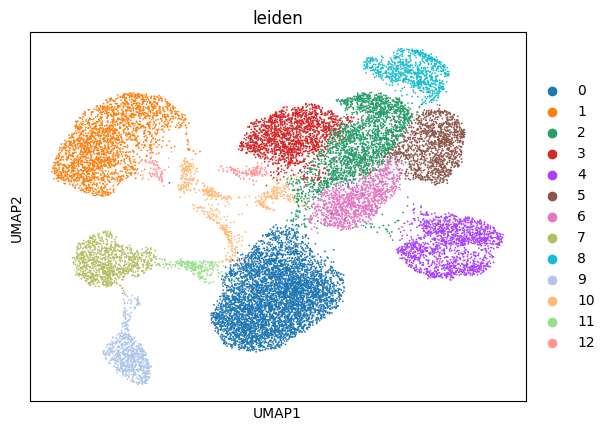

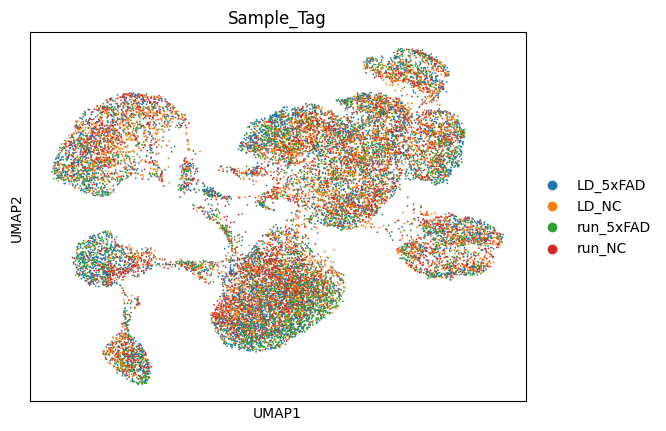

In [18]:
# Plotting
sc.pl.umap(adata_test, color=['leiden'], save='umap_leiden.png')
sc.pl.umap(adata_test, color=['Sample_Tag'], save='umap_sampletag.png')
#sc.pl.umap(adata_test, color=['high_mt'], save='umap_highmt.png')

# Cluster annotation

In [19]:
# Assign unique cell type names to each cluster
assign_unique_cell_type_names(adata_test, cluster_type='class_name')
assign_unique_cell_type_names(adata_test, cluster_type='subclass_name')
# Ensure leiden and annotated_cluster are strings for concatenation
adata_test.obs['leiden'] = adata_test.obs['leiden'].astype(str)
adata_test.obs['cluster_class_name'] = adata_test.obs['cluster_class_name'].astype(str)
adata_test.obs['cluster_subclass_name'] = adata_test.obs['cluster_subclass_name'].astype(str)

# Cluster annotation visualization

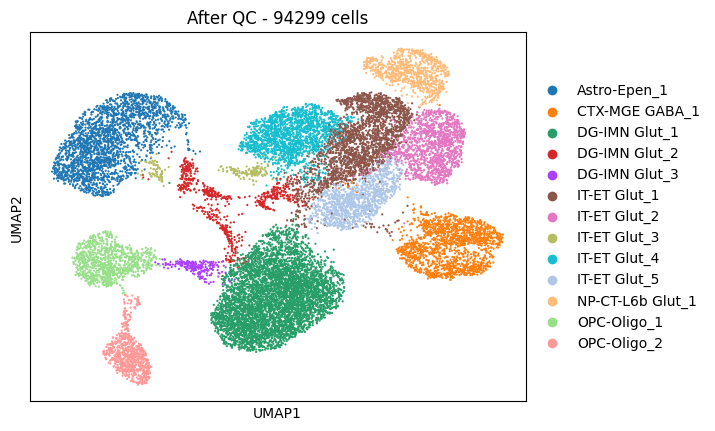

In [20]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata_test, color=['cluster_class_name'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

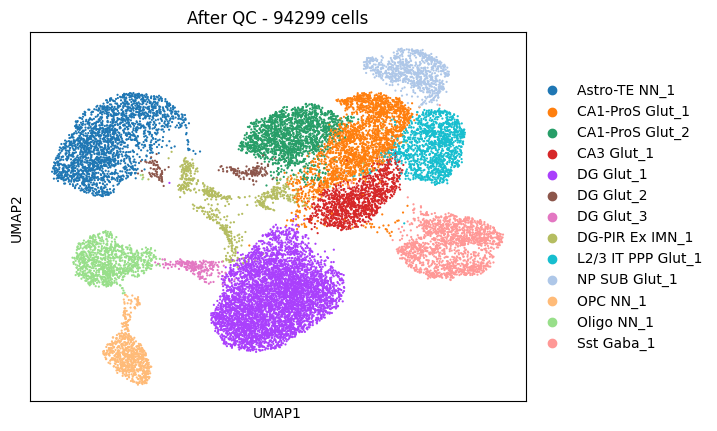

In [21]:
# Plot UMAP with unique cell type annotations
sc.pl.umap(adata_test, color=['cluster_subclass_name'], save='umap_all_groups.png', title=f'After QC - {adata.shape[0]} cells', size=10)

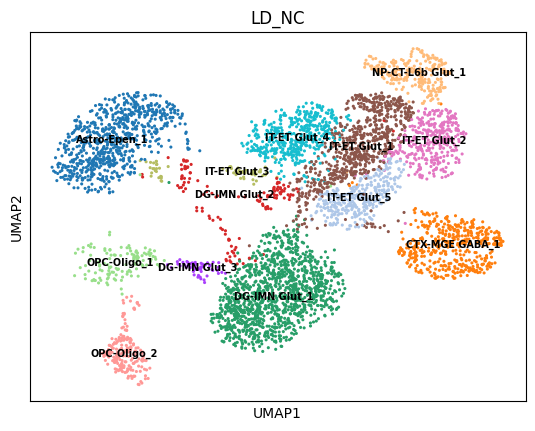

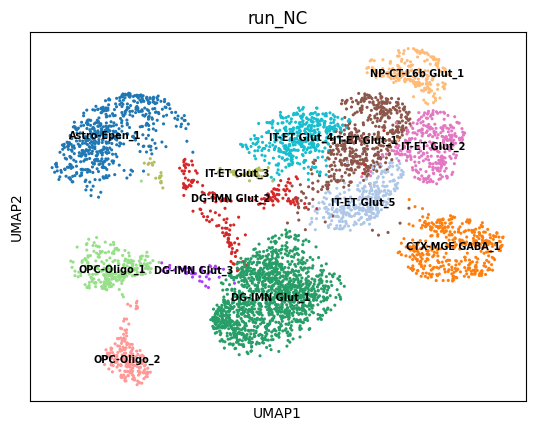

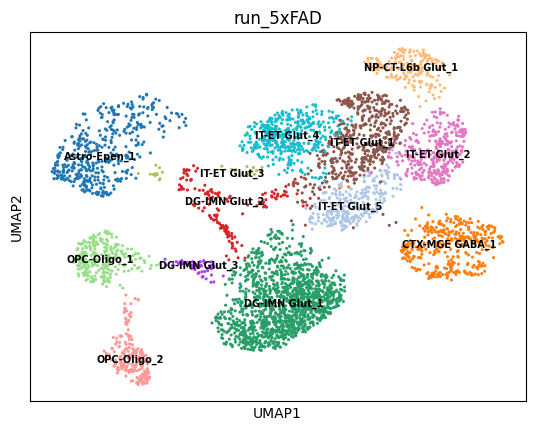

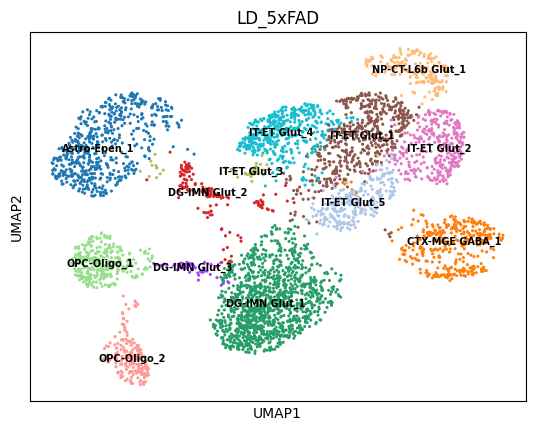

In [22]:
# Plot separately by sample tag
sample_tags = adata_test.obs['Sample_Tag'].unique()
plot_umap(adata_test, sample_tags, cluster_type='cluster_class_name', legend_fontsize=7)

# Clusters composition analysis

In [ ]:
class_level, cluster_type = 'class_name', 'cluster_class_name'

In [ ]:
create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['WT-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['3xTg-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['WT-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['3xTg-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100)

In [ ]:
class_level, cluster_type = 'class_name', 'cluster_class_name'

In [ ]:
create_ditto_plot(adata_test, ['LD_5xFAD', 'LD_NC', 'run_5xFAD', 'run_NC'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata_test, ['LD_5xFAD'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata_test, ['LD_NC'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata_test, ['run_5xFAD'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata_test, ['run_NC'], class_level=class_level, cluster_type=cluster_type, min_cell=100)

# Top contributing genes for each latent dimension

In [ ]:
top_genes = get_top_genes(autoencoder, adata_test, top_n=500)

In [ ]:
#plot_top_contributing_genes(autoencoder, adata_test, latent_dim=40, top_n=10)

# GO term enrichment analysis

In [ ]:
genes_ncbi = query_genes(adata)

In [ ]:
pos_df_results = []
neg_df_results = []
for i in tqdm(range(50)):
    pos_gene_ids = [int(genes_ncbi[x.upper()]) for x in top_genes[i]['positive'] if x.upper() in genes_ncbi.keys()]
    pos_df_result = perform_go_enrichment(pos_gene_ids, [int(x) for x in genes_ncbi.values()])
    
    neg_gene_ids = [int(genes_ncbi[x.upper()]) for x in top_genes[i]['negative'] if x.upper() in genes_ncbi.keys()]
    neg_df_result = perform_go_enrichment(neg_gene_ids, [int(x) for x in genes_ncbi.values()])
    
    pos_df_results.append(pos_df_result)
    neg_df_results.append(neg_df_result)

In [ ]:
with open('pos_df_results.pkl', 'wb') as f:
    pickle.dump(pos_df_results, f)
with open('pos_df_results.pkl', 'rb') as f:
    pos_df_results = pickle.load(f)
with open('neg_df_results.pkl', 'wb') as f:
    pickle.dump(neg_df_results, f)
with open('neg_df_results.pkl', 'rb') as f:
    neg_df_results = pickle.load(f)

In [ ]:
dim=40
display_go_enrichment(pos_df_results[dim], f'latent_dim_{dim}', namespace='BP')
#display_go_enrichment(neg_df_results[dim], f'latent_dim_{dim}', namespace='BP')

# Latent dimensions heatmap

In [ ]:
adata_test.obs['Sample_Tag'].unique()

In [ ]:
adata_test.obs['cluster_class_name'].unique()

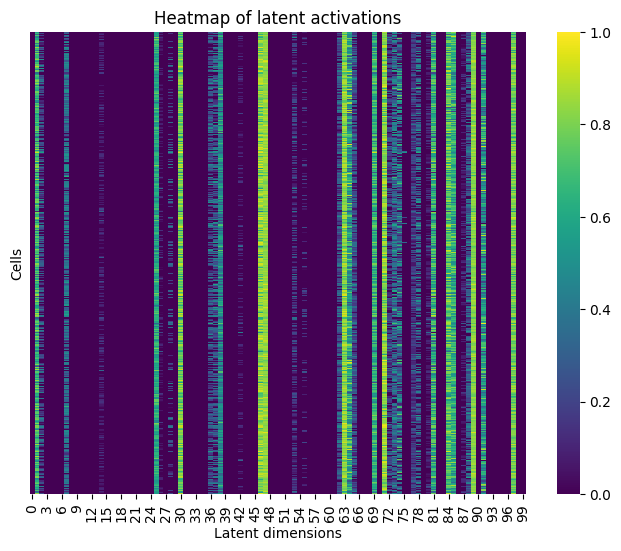

In [23]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['LD_NC'], clusters=['CTX-MGE GABA_1'], subclusters=None, num_cells=500)

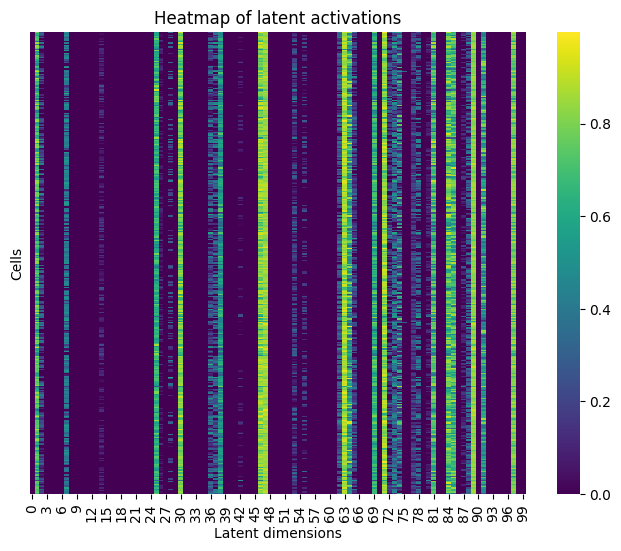

In [24]:
plot_latent_heatmap(autoencoder, data, adata_test, sample_tags=['run_5xFAD'], clusters=['CTX-MGE GABA_1'], subclusters=None, num_cells=500)

# Plot reconstructions

In [ ]:
plot_cell_reconstruction(autoencoder, data, cell_idx=0)

In [ ]:
plot_gene_reconstruction(autoencoder, data, gene_idx=0)